In [1]:
import os
import sys
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [2]:
dirs = os.listdir(os.path.join("/kaggle/input/celebrity-face-image-dataset/", "Celebrity Faces Dataset"))
paths_raw = []
for d in dirs:
    l = os.listdir(os.path.join("/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset", d))
    for item in l:
        paths_raw.append("/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset/" + d + '/' + item)

paths = []
for p in paths_raw:
    im = cv2.imread(p)
    if im.shape[0] % 2 == 0 and im.shape[1] % 2 == 0:
        paths.append(p)

print(f'{len(paths)} images')

1200 images


In [3]:
images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in paths]
data = [[cv2.resize(im, (im.shape[1]//2, im.shape[0]//2)), im] for im in images]

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data):
        super(ImageDataset, self).__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
#        x = torch.tensor(x).reshape((x.shape[2], x.shape[0], x.shape[1]))
#        y = torch.tensor(y).reshape((y.shape[2], y.shape[0], y.shape[1]))
        x = torch.tensor(x).permute(2, 0, 1)
        y = torch.tensor(y).permute(2, 0, 1)
        return x / 255, y / 255

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
lr = 3e-4
epochs = 10
batch_size = 16

Device: cuda


In [6]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(weights=VGG19_Weights.DEFAULT).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(self, in_channels, out_channels, use_activation=True, use_BatchNorm=True, **kwargs):
        super().__init__()
        self.use_activation = use_activation
        self.use_BatchNorm = use_BatchNorm
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        if use_BatchNorm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.ac = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.cnn(x)
        if self.use_BatchNorm:
            x = self.bn(x)
        x1 = self.ac(x)
        return x1 if self.use_activation else x

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (scale_factor**2), kernel_size=2, stride=1, padding=1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.b2 = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, use_activation=False)

    def forward(self, x0):
        x = self.b1(x0)
        x = self.b2(x)
        return x + x0

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        c = self.final(c)
        return torch.sigmoid(c)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [7]:
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 203MB/s]  


In [8]:
train = ImageDataset(data)

def custom_collate(batch):
    images_low = [item[0] for item in batch]
    images_high = [item[1] for item in batch]
    return images_low, images_high

dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, collate_fn=custom_collate, num_workers=2)

In [37]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(loader)
    disc_loss = 0
    gen_loss = 0
    gen.train()
    disc.train()
    for idx, (low_res, high_res) in enumerate(loop):
        for lr, hr in zip(low_res, high_res):
            hr = hr.unsqueeze(0).to(device)
            lr = lr.unsqueeze(0).to(device)
        
            fake = gen(lr)
            disc_real = disc(hr)
            disc_fake = disc(fake.detach())
            disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
            disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
            disc_loss = disc_loss_fake + disc_loss_real
            disc_loss.backward()
        
            disc_fake = disc(fake)
            adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
            loss_for_vgg = 0.006 * vgg_loss(fake, hr)
#            mse_loss = 0.003 * mse(fake, hr)
            mse_loss = 0.03 * mse(fake, hr)
            gen_loss = loss_for_vgg + adversarial_loss + mse_loss
            gen_loss.backward()

        opt_disc.step()
        opt_gen.step()
        opt_disc.zero_grad()
        opt_gen.zero_grad()

    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    x, y = data[random.randint(0, len(data)-1)]
    x = torch.tensor(x).permute(2, 0, 1) / 255
    y = torch.tensor(y).permute(2, 0, 1) / 255
    gen.eval()
    fake = gen(x.unsqueeze(0).to(device))

    im_lr = x.squeeze().permute(1, 2, 0).cpu()
    axs[0].set_axis_off()
    axs[0].imshow(im_lr)
    axs[0].set_title("low res")
#    im_gen = fake.reshape((fake.shape[2], fake.shape[3], 3)).detach().cpu()
    im_gen = fake.squeeze().permute(1, 2, 0).detach().cpu()
    axs[1].set_axis_off()
    axs[1].imshow(im_gen)
    axs[1].set_title("reconstructed")
#    im_hr = hr.reshape((hr.shape[2], hr.shape[3], 3)).cpu()
    im_hr = y.squeeze().permute(1, 2, 0).cpu()
    axs[2].set_axis_off()
    axs[2].imshow(im_hr)
    axs[2].set_title("high res")
    plt.show()
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

epoch  1 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

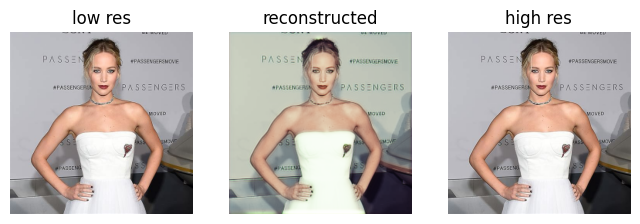

epoch  2 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

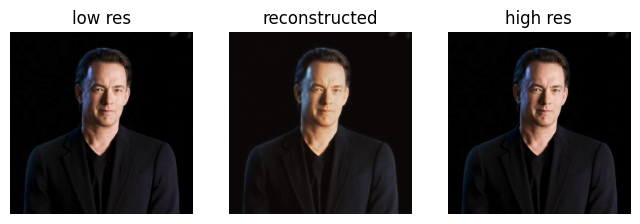

epoch  3 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

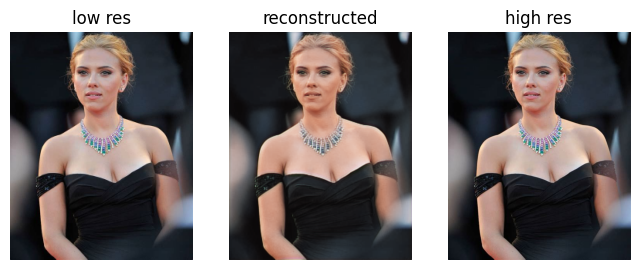

epoch  4 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

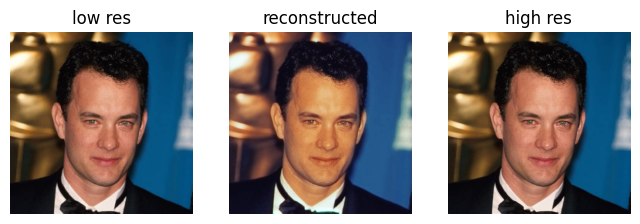

epoch  5 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

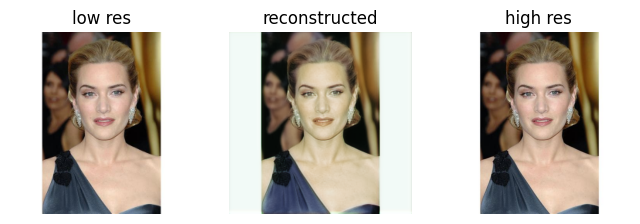

epoch  6 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

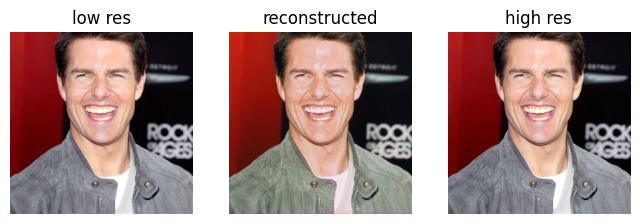

epoch  7 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

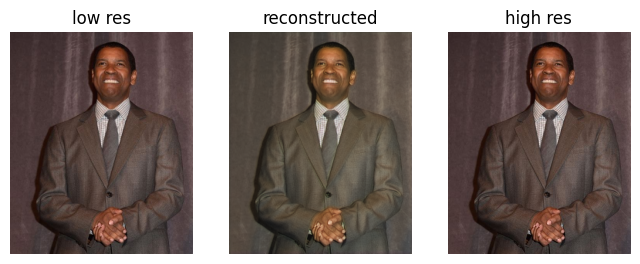

epoch  8 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

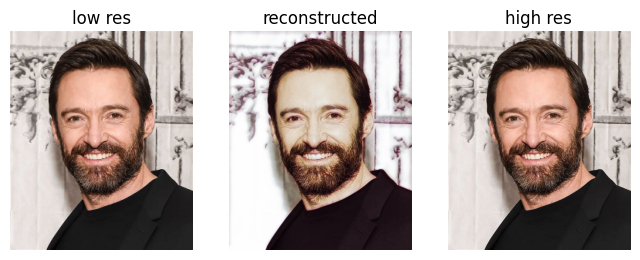

epoch  9 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

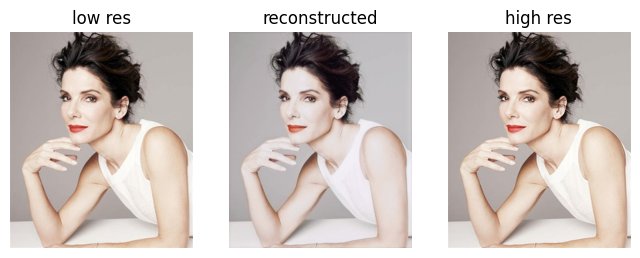

epoch  10 / 10


  0%|          | 0/75 [00:00<?, ?it/s]

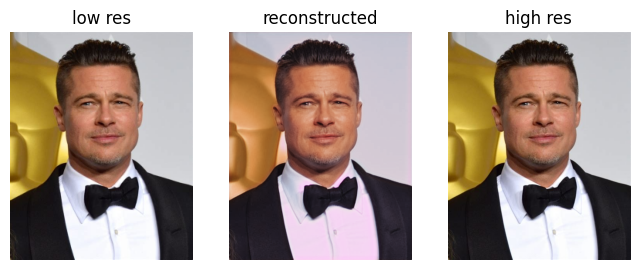

In [38]:
d_losses = []
g_losses = []
for epoch in range(epochs):
     #plot_examples(gen)
     print("epoch ", epoch+1, "/", epochs)
     gen_loss, disc_loss = train_fn(dataloader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)

     d_losses.append(disc_loss)
     g_losses.append(gen_loss)

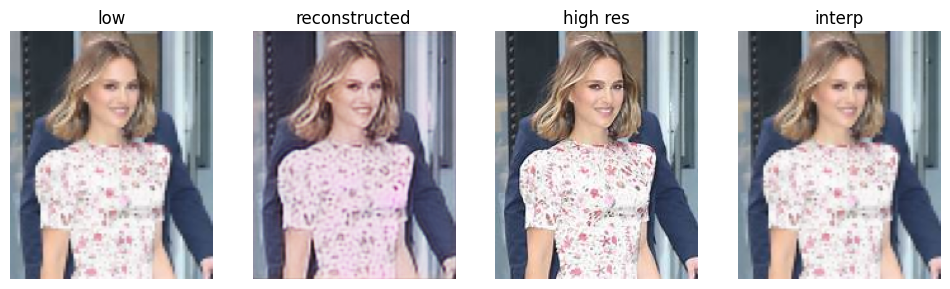

In [86]:
orig = images[377]
half = cv2.resize(orig, (orig.shape[1]//2, orig.shape[0]//2))
    
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
x_half = torch.tensor(half).permute(2, 0, 1) / 255
y = torch.tensor(orig).permute(2, 0, 1) / 255
gen.eval()
fake_half = gen(x_half.unsqueeze(0).to(device))
    
im_half = x_half.squeeze().permute(1, 2, 0).cpu()
axs[0].set_axis_off()
axs[0].imshow(im_half)
axs[0].set_title("low")
    
im_gen_half = fake_half.squeeze().permute(1, 2, 0).detach().cpu()
axs[1].set_axis_off()
axs[1].imshow(im_gen_half)
axs[1].set_title("reconstructed")
    
im_hr = y.squeeze().permute(1, 2, 0).cpu()
axs[2].set_axis_off()
axs[2].imshow(im_hr)
axs[2].set_title("high res")

im_interp = cv2.resize(np.array(im_half), (orig.shape[1]//2, orig.shape[0]//2), interpolation=cv2.INTER_CUBIC)
axs[3].set_axis_off()
axs[3].imshow(im_interp)
axs[3].set_title("interp")
    
plt.show()

In [87]:
torch.save(gen.state_dict(), "gen.pth")
torch.save(disc.state_dict(), "disc.pth")

In [9]:
!ls /kaggle/input/sr_gan/pytorch/default/1/gen.pth

disc.pth  gen.pth


In [12]:
gen = Generator()
gen_state_dict = torch.load('/kaggle/input/sr_gan/pytorch/default/1/gen.pth', weights_only=True, map_location=torch.device('cpu'))
gen.load_state_dict(gen_state_dict)

<All keys matched successfully>

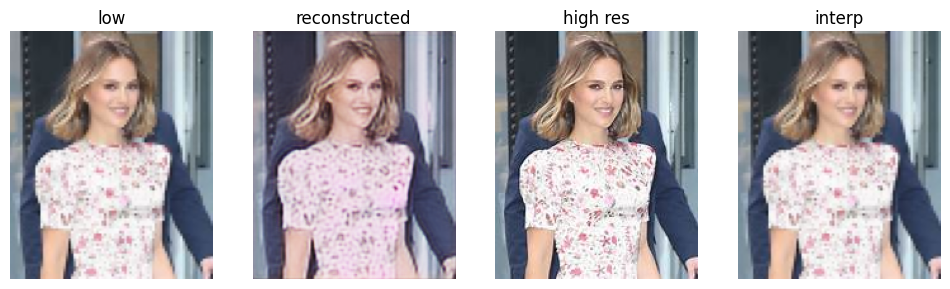

In [13]:
orig = images[377]
half = cv2.resize(orig, (orig.shape[1]//2, orig.shape[0]//2))
    
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
x_half = torch.tensor(half).permute(2, 0, 1) / 255
y = torch.tensor(orig).permute(2, 0, 1) / 255
gen.eval()
fake_half = gen(x_half.unsqueeze(0))
    
im_half = x_half.squeeze().permute(1, 2, 0)
axs[0].set_axis_off()
axs[0].imshow(im_half)
axs[0].set_title("low")
    
im_gen_half = fake_half.squeeze().permute(1, 2, 0).detach()
axs[1].set_axis_off()
axs[1].imshow(im_gen_half)
axs[1].set_title("reconstructed")
    
im_hr = y.squeeze().permute(1, 2, 0)
axs[2].set_axis_off()
axs[2].imshow(im_hr)
axs[2].set_title("high res")

im_interp = cv2.resize(np.array(im_half), (orig.shape[1]//2, orig.shape[0]//2), interpolation=cv2.INTER_CUBIC)
axs[3].set_axis_off()
axs[3].imshow(im_interp)
axs[3].set_title("interp")
    
plt.show()